In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from scipy import sparse
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import numpy as np
import warnings
from sklearn.preprocessing import LabelEncoder
import tkinter as tk
from tkinter import ttk
import pandas as pd
import tkinter.messagebox as messagebox
import csv
warnings.filterwarnings("ignore")

pd.set_option("display.min_rows", 1)
pd.set_option("display.max_rows", 20)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [110]:
url = "https://www.morele.net/kategoria/laptopy-31/"
page = requests.get(url)

soup = BeautifulSoup(page.content, 'html.parser')

number_of_pages = int(soup.find('div', attrs={'class': 'pagination-btn-nolink-anchor'}).get('data-page'))

data = []

def get_section(section_name, index= None):
            try:
                zupa = soup.find(lambda tag: tag if tag.name == "div" and f'{section_name}' in [child.text for child in tag.children] else None)
                if zupa:
                    if index is not None:
                        zupa = zupa.find_all('div', attrs={'class': 'specification__row'})[index].find('span', attrs={'class': 'specification__value'})
                    else:
                        zupa = len(zupa.find_all('div', attrs={'class': 'specification__row'}))
                    return zupa   
                else:
                    raise Exception

            except Exception as e:
                print(f'Error in {section_name}, Usuwam')
                return None

for i in range(1,number_of_pages):
    url = f"https://www.morele.net/kategoria/laptopy-31/,,,,,,,,0,,,,/{i}/"
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    
    laptops = soup.find_all('div', attrs={'class': 'cat-product card'}, recursive=True)

    for laptop in laptops:
        href = laptop.find('a', attrs={'class': 'productLink'})['href']
        href_link = "https://www.morele.net" + href
        
        page = requests.get(href_link)
        soup = BeautifulSoup(page.content, 'html.parser')

        try:

            name = soup.find('h1', attrs={'class': 'prod-name'}).text
            
            price = float(soup.find('div', attrs={'class': 'product-price'})['data-price'])
            
            popularity = 0
            pop_div = soup.find('div', attrs={'class': 'prod-sold'})
            if(pop_div != None):
                popularity = pop_div.text.strip().replace('\n', ' ').split(" ")[1]
                popularity = int(popularity)

        except Exception as e:
            continue

        try:
            ram = get_section(section_name='Pamięć', index=0) 
            gpu = None
            gpu_mem = False
            if get_section(section_name="Karta graficzna") == 4:
                if get_section(section_name="Karta graficzna", index=1).text.strip() == "Brak":
                    gpu = get_section(section_name="Karta graficzna", index=0)
                    gpu_mem = 0
                else:
                    gpu = get_section(section_name="Karta graficzna", index=1)
                    gpu_mem = int(get_section(section_name="Karta graficzna", index=2).text.strip().split(" ")[0])
            else:
                raise Exception

            cpu = get_section(section_name='Procesor', index=1)
            cpu_timing = get_section(section_name='Procesor', index=2)
            cpu_cores = get_section(section_name='Procesor', index=3)
            cpu_threads = get_section(section_name='Procesor', index=3)
            screen_size = get_section(section_name='Wyświetlacz', index=0)
            system = get_section(section_name='Oprogramowanie', index=0)
        except Exception as e:
            continue
        
        
        if all([ram, gpu, cpu, cpu_timing, cpu_threads, cpu_cores, screen_size, system]):
            try:
                ram = int(ram.text.strip().split(" ")[0])
                gpu = gpu.text.strip()
                cpu = cpu.text.strip()
                cpu_timing = float(cpu_timing.text.strip().split("/")[0].replace("GHz", ""))
                cpu_cores = int(cpu_cores.text.strip().split("/")[0])
                cpu_threads = int(cpu_threads.text.strip().split("/")[1])
                screen_size = float(screen_size.text.strip().replace("\"", ""))
                system = system.text.strip()
            except Exception as e:
                continue

        else:
            
            continue
        
        data.append((name, price, popularity, ram, gpu, gpu_mem, cpu, cpu_timing, cpu_cores, cpu_threads, screen_size, system ))
      
df = pd.DataFrame(data, columns=['Nazwa', 'Cena', 'Popularność', 'RAM(GB)', 'GPU','Pamięć GPU(GB)','CPU', 'Taktowanie(GHz)', 'Rdzenie', 'Wątki', 'Przekątna', 'System'])
df["Nazwa"] = df["Nazwa"].str.replace("Laptop ", "")
df["Indeks"] = df.index
df.to_csv("laptops.csv", index=False, encoding='utf-8', quoting=csv.QUOTE_NONNUMERIC, quotechar='"')


Error in Pamięć, Usuwam
Error in Karta graficzna, Usuwam
Error in Pamięć, Usuwam
Error in Karta graficzna, Usuwam
Error in Pamięć, Usuwam
Error in Karta graficzna, Usuwam
Error in Pamięć, Usuwam
Error in Karta graficzna, Usuwam
Error in Pamięć, Usuwam
Error in Karta graficzna, Usuwam
Error in Karta graficzna, Usuwam
Error in Pamięć, Usuwam
Error in Karta graficzna, Usuwam
Error in Pamięć, Usuwam
Error in Karta graficzna, Usuwam
Error in Karta graficzna, Usuwam
Error in Pamięć, Usuwam
Error in Karta graficzna, Usuwam
Error in Pamięć, Usuwam
Error in Karta graficzna, Usuwam
Error in Pamięć, Usuwam
Error in Karta graficzna, Usuwam
Error in Karta graficzna, Usuwam
Error in Pamięć, Usuwam
Error in Karta graficzna, Usuwam
Error in Procesor, Usuwam
Error in Procesor, Usuwam
Error in Procesor, Usuwam
Error in Procesor, Usuwam
Error in Pamięć, Usuwam
Error in Karta graficzna, Usuwam
Error in Procesor, Usuwam
Error in Procesor, Usuwam
Error in Procesor, Usuwam
Error in Procesor, Usuwam
Error in 

<AxesSubplot: >

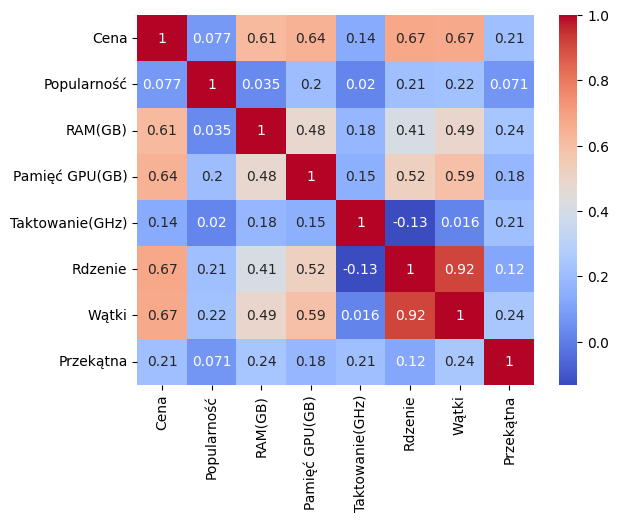

In [4]:
df = pd.read_csv('laptops.csv')
df = df.drop(columns=['Indeks'])

corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

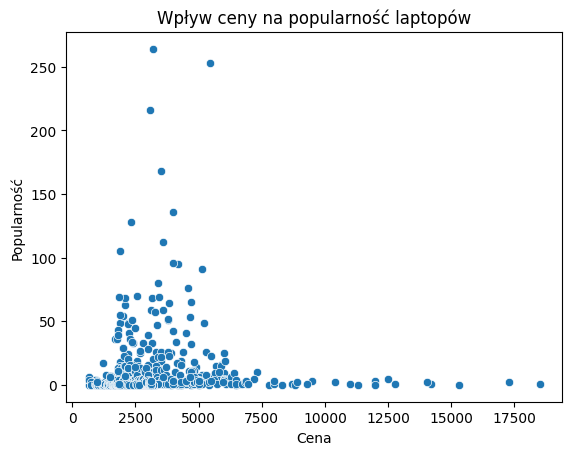

In [4]:
df = pd.read_csv('laptops.csv')

plt.title('Wpływ ceny na popularność laptopów')
sns.scatterplot(data=df, x="Cena", y="Popularność")
plt.show()

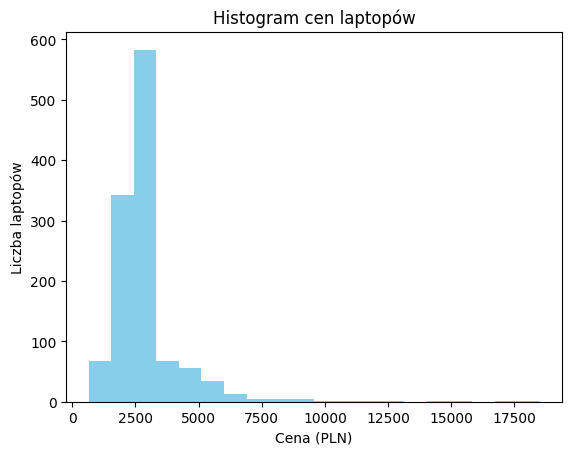

In [5]:
plt.hist(df['Cena'], bins=20, color='skyblue')

plt.title('Histogram cen laptopów')
plt.xlabel('Cena (PLN)')
plt.ylabel('Liczba laptopów')

plt.show()

In [3]:

data = pd.read_csv("laptops.csv", index_col="Indeks")
laptops = data.copy(deep=True)

x = data.drop(columns=["Nazwa"])


In [4]:
le = LabelEncoder()

main_dict = {}
COLS_TO_ENCODE = ["CPU", "GPU", "System"]


for col in COLS_TO_ENCODE:
    buffer_dict = {}
    
    le.fit(x[col])
    classes = le.classes_
    values = le.transform(classes)

    x[col] = le.transform(x[col])

    for value, key in zip(classes, values):
        buffer_dict[key] = value
        
    main_dict[col] = buffer_dict.copy()
np.set_printoptions(precision=2, suppress=True)
        

In [5]:

laptops = pd.read_csv("laptops.csv")

app = tk.Tk()
app.geometry('1800x1200')
app.title("Rekomendacja laptopów")

tree = ttk.Treeview(app)
tree.pack(fill=tk.BOTH, expand=True)

tree["columns"] = ("Indeks", "Cena", "Popularność", "RAM(GB)", "GPU", "Pamięć GPU(GB)", "CPU", "Taktowanie(GHz)", "Rdzenie", "Wątki", "Przekątna", "System")


tree.column("Indeks", width=50, stretch=True)
tree.heading("Indeks", text="Indeks", anchor='w', command=lambda: tree.focus(""))
tree.column("Cena", width=50, stretch=True)
tree.heading("Cena", text="Cena")
tree.column("Popularność", width=100, stretch=True)
tree.heading("Popularność", text="Popularność")
tree.column("RAM(GB)", width=60, stretch=True)
tree.heading("RAM(GB)", text="RAM(GB)")
tree.column("GPU", width=100, stretch=True)
tree.heading("GPU", text="GPU")
tree.column("Pamięć GPU(GB)", width=100, stretch=True)
tree.heading("Pamięć GPU(GB)", text="Pamięć GPU(GB)")
tree.column("CPU", width=150, stretch=True)
tree.heading("CPU", text="CPU")
tree.column("Taktowanie(GHz)", width=100, stretch=True)
tree.heading("Taktowanie(GHz)", text="Taktowanie(GHz)")
tree.column("Rdzenie", width=100, stretch=True)
tree.heading("Rdzenie", text="Rdzenie")
tree.column("Wątki", width=100, stretch=True)
tree.heading("Wątki", text="Wątki")
tree.column("Przekątna", width=100, stretch=True)
tree.heading("Przekątna", text="Przekątna")
tree.column("System", width=150, stretch=True)
tree.heading("System", text="System")


for index, row in laptops.iterrows():
    tree.insert("", tk.END,  values=(row['Indeks'], row['Cena'], row['Popularność'], row['RAM(GB)'], row['GPU'], row['Pamięć GPU(GB)'], row['CPU'], row['Taktowanie(GHz)'], row['Rdzenie'], row['Wątki'], row['Przekątna'], row['System']))

default_weights = [0.2, 0.1, 0.2, 0.2, 0.2, 0, 0, 0, 0, 0.1, 0]
frame = tk.Frame(app)

weight_label = tk.Label(frame, text="Wprowadź wagi:")
weight_label.pack(side='left')


weight_entry = tk.Entry(frame, width=25, justify='center')
weight_entry.insert(tk.END, "0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0")
weight_entry.pack(side='left')

frame.pack(side='left', padx=25)

weights = []

def save_weights():
    global weights
    weights_entry = weight_entry.get().strip()
    
    if not weights_entry:
        weights = default_weights.copy()
        return
    try:
        weights = list(map(float, weights_entry.split(",")))
        if all(0 <= w <= 1 for w in weights):
            weights = weights
            return
    except ValueError:
        pass
    messagebox.showerror("Błąd", "Wprowadź poprawne wagi z zakresu 0-1 oddzielone przecinkami.")


save_button = tk.Button(frame, text="Zapisz wagi", command=save_weights)
save_button.pack(side=tk.LEFT)

def show_info():
    messagebox.showinfo("Informacja", """Wagi muszą być podane w zakresie od 0.01 do 1,
Wagi muszą być podawane po przecinku,
Wagi odpowiadają kolejno:  
Cena, Popularność, RAM(GB), GPU,Pamięć GPU(GB), CPU, Taktowanie(GHz), Rdzenie, Wątki, Przekątna, System.
"""
)
info_button = tk.Button(frame, text="?", command=show_info)
info_button.pack()

selected_index = 0

def select_item(event):
    global selected_index
    selected_item = tree.focus()
    selected_index = tree.item(selected_item)['values'][0]

tree.bind("<ButtonRelease-1>", select_item)

def generate_recommendations(num_recommendations=5):
    global weights
    def weighted_distance(x, y, weights):
        distance = np.sqrt((x - y) ** 2)
        weighted_distance = distance * np.array(weights)
        return np.sum(weighted_distance)

    if not weights:
        weights.extend(default_weights)

    knn = NearestNeighbors(
        n_neighbors=num_recommendations,
        algorithm="brute",
        metric=weighted_distance,
        metric_params={"weights": weights},
    )
    knn.fit(x)
    product = x.loc[selected_index]
    distances, indices = knn.kneighbors([product])
    recommendations = data.iloc[indices.flatten()]


    window = tk.Toplevel(app)
    window.title("Rekomendacje")
    window.geometry("1900x1200")

    table = ttk.Treeview(window, columns=list(recommendations.columns))
    table.pack(fill='both', expand=True)
    table.column("#0", width=30)
    
    table.heading("#0", text="Indeks")
    for column in recommendations.columns:
        table.heading(column, text=column, anchor="w")
        table.column(column, minwidth=50, width=100, stretch=True)

    for index, row in recommendations.iterrows():
        values = [row[column] for column in recommendations.columns]
        table.insert("", "end", text=index, values=values)


def change_num_recommendations():
    num_recommendations = int(num_recs_entry.get())
    generate_button.config(command=lambda: generate_recommendations(num_recommendations))
    messagebox.showinfo("Zmiana ilości rekomendacji", f"Ilość rekomendacji ustawiona na: {num_recommendations}")

frame1 = tk.Frame(app)

num_recs_label = tk.Label(frame1, text="Wprowadź ilość rekomendacji:")
num_recs_label.pack(side='left')

num_recs_entry = tk.Entry(frame1, width=10, justify='center')
num_recs_entry.insert(tk.END, "5")  
num_recs_entry.pack(side='left')

change_button = tk.Button(frame1, text="Zmień ilość rekomendacji", command=change_num_recommendations)
change_button.pack(side='left')

frame1.pack(side='right', padx=20)

generate_button = tk.Button(app, text="Generuj rekomendacje", command=generate_recommendations, font=('Arial', 20 ))
generate_button.pack(pady=50)


app.mainloop()